<a href="https://colab.research.google.com/github/NASSERHMMN/FAMILY/blob/main/GB_RELIEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

In [2]:
df = pd.read_csv("data.csv")


In [3]:
lis = []
for i in range(len(df)) :
  if df['diagnosis'][i] == 'M' :
    lis.append(1)
  else :
    lis.append(0)
Y_ = np.array(lis)

In [4]:
Y_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [5]:
clmns = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [6]:
def accuracy(m) :
  return (m[0][0]+m[1][1])/(m[0][0]+m[0][1]+m[1][0]+m[1][1])

def sensibility(m) :
  return m[1][1]/(m[1][1]+m[1][0])

def specificity(m) :
  return m[0][0]/(m[0][0]+m[0][1])

def mcc(m) :
  a = m[0][0]*m[1][1] - m[0][1]*m[1][0]
  b = np.sqrt((m[1][1]+m[0][1])*(m[1][1]+m[1][0])*(m[0][0]+m[0][1])*(m[0][0]+m[1][0]))
  return a/b

def most_k_imp(scrs_, k) :
  scrs = scrs_.copy()
  keys = scrs.keys()
  max_scr_key = 0
  for ke in keys :
    max_scr_key = ke
    break
  top_scrs = []
  for i in range(k) :
    for ke in keys:
      if scrs[ke] > scrs[max_scr_key] :
        max_scr_key = ke
    top_scrs.append(max_scr_key)
    scrs[max_scr_key] = 0
  return top_scrs

In [7]:
def cross_val(X, Y, algorithm, features=-1, cross_validation='cv', k=5, balancing_method='under_sampling') :
  if (features != -1) :
    X_ = pd.DataFrame({feature : df[feature] for feature in features})
    X_ = X_.to_numpy()
    Y_ = df["diagnosis"]
    Y_ = Y_.to_numpy()
  else :
    X_ = X
    Y_ = Y
  if cross_validation == 'cv' :
    splt = KFold(n_splits=k, random_state=1, shuffle=True)
    splits = splt.split(X_)
  elif cross_validation == 'skf' :
    splt = StratifiedKFold(n_splits=k)
    splits = splt.split(X_, Y_)
  model_predictions = []
  actual_labels = []
  scores = []
  if algorithm == 'Gradient_Boosting' :
    model = GradientBoostingClassifier()
  elif algorithm == 'XGradient_Boosting' :
    model = XGBClassifier()
  elif algorithm == 'Logistic_Regression' :
    model = LogisticRegression(random_state=0,  max_iter=100)
  elif algorithm == 'Random_Forest' :
    model = RandomForestClassifier(max_depth=5, random_state=0)
  elif algorithm == 'Gaussian_nb' :
    model = GaussianNB()
  elif algorithm == 'K_Nearest_Neighbors' :
    model = KNeighborsClassifier(n_neighbors=7)
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  n = 0
  for train_index, test_index in splits :
    X_train, Y_train = X_[train_index], Y_[train_index]
    X_test, Y_test = X_[test_index], Y_[test_index]
    if (balancing_method != None and cross_validation == 'cv') :
      if balancing_method == "over_sampling" :
        balancing = RandomOverSampler(random_state=0)
      elif balancing_method == "smote" :
        balancing = SMOTE()
      elif balancing_method == "under_sampling" :
        balancing = RandomUnderSampler(random_state=0)
      X_train, Y_train = balancing.fit_resample(X_train, Y_train)
    model = model.fit(X_train, Y_train)
    #ROC Plot
    viz = RocCurveDisplay.from_estimator(model, X_test, Y_test, name="ROC fold {}".format(n), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    model_predictions.append(model.predict(X_test))
    actual_labels.append(Y_test)
    scores.append(model.score(X_test, Y_test))
    n += 1
  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.2)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)
  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.",)
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic : " + algorithm)
  ax.legend(loc="lower right")
  plt.show()
  performance_metrics = [{} for i in range(k+1)]
  for i in range(k) :
    performance_metrics[i]['confusion_matrix'] = confusion_matrix(model_predictions[i], actual_labels[i])
    conf_mat = performance_metrics[i]['confusion_matrix']
    performance_metrics[i]['accuracy'] = accuracy(conf_mat)
    performance_metrics[i]['sensibility'] = sensibility(conf_mat)
    performance_metrics[i]['specificity'] = specificity(conf_mat)
    performance_metrics[i]['mcc'] = mcc(conf_mat)
  performance_metrics[k]['accuracy_average'] = np.mean([performance_metrics[i]['accuracy'] for i in range(k)])
  #performance_metrics[k]['accuracy_deviation'] = np.std([performance_metrics[i]['accuracy'] for i in range(k)])
  performance_metrics[k]['sensibility_average'] = np.mean([performance_metrics[i]['sensibility'] for i in range(k)])
  #performance_metrics[k]['sensibility_deviation'] = np.std([performance_metrics[i]['sensibility'] for i in range(k)])
  performance_metrics[k]['specificity_average'] = np.mean([performance_metrics[i]['specificity'] for i in range(k)])
  #performance_metrics[k]['specificity_deviation'] = np.std([performance_metrics[i]['specificity'] for i in range(k)])
  performance_metrics[k]['mcc_average'] = np.mean([performance_metrics[i]['mcc'] for i in range(k)])
  #performance_metrics[k]['mcc_deviation'] = np.std([performance_metrics[i]['mcc'] for i in range(k)])
  return performance_metrics

In [8]:
from mlxtend.plotting import plot_confusion_matrix
def plt_conf_mat(mat) :
  fig, ax = plot_confusion_matrix(conf_mat=mat)
  plt.show()

In [9]:
X = df.copy()
X.drop(['id','diagnosis', 'Unnamed: 32'],axis=1,inplace=True)
X = X.to_numpy()
Y = df["diagnosis"]
Y = Y.to_numpy()

In [12]:
from ITMO_FS.filters.univariate import reliefF_measure


In [13]:
def top_k(scrs_, k) :
  fs = [False for i in range(30)]
  n = len(scrs_)
  scrs = scrs_.copy()
  for i in range(0, k) :
    max_index = 0
    for j in range(n) :
      if scrs[j] > scrs[max_index] :
        max_index = j
    fs[max_index] = True
    scrs[max_index] = -2
  return fs

In [14]:
def transform(X, fs) :
  X_ = df.copy()
  X_.drop(['id','diagnosis', 'Unnamed: 32'], axis=1, inplace=True)
  for i in range(len(fs)) :
    if fs[i] == False :
      X_.drop([clmns[i]], axis=1, inplace=True)
  X_ = X_.to_numpy()
  return X_



In [15]:
scores = reliefF_measure(X, Y_)
scores

array([ 0.02158508,  0.04486682,  0.02377382,  0.01652306,  0.04339287,
        0.09224383,  0.0797514 ,  0.07206191,  0.0398216 ,  0.03693144,
        0.01081284,  0.00876429,  0.00770932,  0.00617992, -0.00646522,
        0.0274274 ,  0.00331678,  0.01685149,  0.01567609,  0.0023432 ,
        0.0302869 ,  0.09380961,  0.03644627,  0.02387131,  0.1187733 ,
        0.13801201,  0.10644972,  0.15353454,  0.06871657,  0.06545504])

In [16]:
Algo = 'Gradient_Boosting'

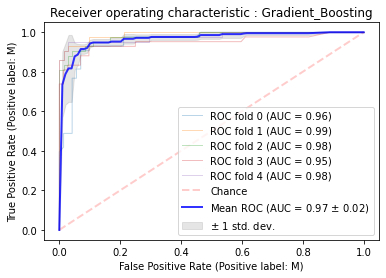

{'accuracy_average': 0.9297469337059463,
 'mcc_average': 0.8496958722130795,
 'sensibility_average': 0.9274098943418583,
 'specificity_average': 0.9322829900839054}

In [17]:
X_5 = transform(X, top_k(scores, 5))
perf_5 = cross_val(X_5, Y, Algo, cross_validation='skf')
perf_5[5]

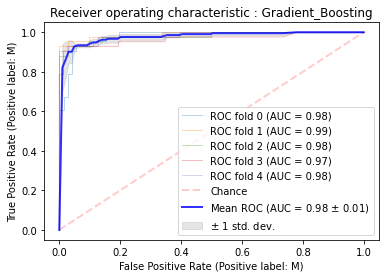

{'accuracy_average': 0.9455208818506444,
 'mcc_average': 0.8841969301652461,
 'sensibility_average': 0.9395227995758217,
 'specificity_average': 0.9503728176201987}

In [18]:
X_10 = transform(X, top_k(scores, 10))
perf_10 = cross_val(X_10, Y, Algo, cross_validation='skf')
perf_10[5]

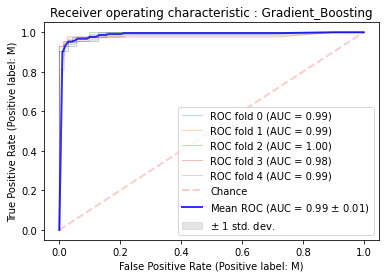

{'accuracy_average': 0.9543083372147182,
 'mcc_average': 0.9023908780954424,
 'sensibility_average': 0.9563931098307311,
 'specificity_average': 0.9537278586201177}

In [19]:
X_15 = transform(X, top_k(scores, 15))
perf_15 = cross_val(X_15, Y, Algo, cross_validation='skf')
perf_15[5]

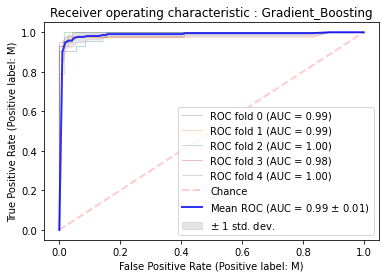

{'accuracy_average': 0.9595870206489675,
 'mcc_average': 0.9135480166002201,
 'sensibility_average': 0.9613124274099883,
 'specificity_average': 0.9588567150982741}

In [20]:
X_20 = transform(X, top_k(scores, 20))
perf_20 = cross_val(X_20, Y, Algo, cross_validation='skf')
perf_20[5]